# Lecture 14 – Data 100, Fall 2023

Data 100, Fall 2023

[Acknowledgments Page](https://ds100.org/fa23/acks/)

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None 
warnings.simplefilter(action='ignore', category=UserWarning)
np.random.seed(42)

## Implementing OLS in Code

Let's explore the Python syntax for performing ordinary least squares programmatically.

Today, we will work with the `penguins` dataset, which contains information about penguins observed by field biologists. For simplicity, we will only consider Adelie penguins.

In [36]:
penguins = sns.load_dataset("penguins")
penguins = penguins[penguins["species"] == "Adelie"].dropna()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


We will construct a model to predict a penguin's bill length from its flipper length and body mass. Our model will take the form:

$$\text{bill depth} = \theta_0 + \theta_1 \text{flipper length} + \theta_2 \text{body mass}$$

We start by constructing a design matrix `X` containing our input features and a target vector `y`.

In [37]:
# Add a bias column of all ones to `penguins`
penguins["bias"] = np.ones(len(penguins), dtype=int) 

# Define the design matrix, X...
X = penguins[["bias", "flipper_length_mm", "body_mass_g"]].to_numpy()

# ...as well as the target variable, y
Y = penguins[["bill_depth_mm"]].to_numpy()

In our lecture on ordinary least squares, we used the geometry of linear algebra to derive the OLS estimate for the optimal model parameters:

$$\hat{\theta} = (\mathbb{X}^{\top}\mathbb{X})^{-1}\mathbb{X}^{\top}\mathbb{Y}$$

There are three operations we need to perform here: multiplying matrices, taking transposes, and finding inverses. 

* To perform matrix multiplication, use the `@` operator
* To take a transpose, call the `.T` attribute of an array or DataFrame
* To compute an inverse, use NumPy's in-built method `np.linalg.inv`

Putting this all together, we can compute the OLS estimate for the optimal model parameters, stored in the array `theta_hat`.

In [38]:
theta_hat = np.linalg.inv(X.T @ X) @ X.T @ Y
theta_hat

array([[1.10029953e+01],
       [9.82848689e-03],
       [1.47749591e-03]])

To make predictions using the fitted model parameters, we apply the model:

$$\hat{\mathbb{Y}} = \mathbb{X} \hat{\theta}$$

In [39]:
y_hat = X @ theta_hat

## `sklearn`

`sklearn` is a popular Python library for building and fitting models. In this lecture, we will walk through the general workflow for writing code for `sklearn`. While our examples will be focused on linear models, `sklearn` is highly adaptable for use on other (more complex) kinds of models. We'll see examples of this later in the semester. 

There are three steps to creating and using a model in `sklearn`. 

**(1) Initialize an instance of the model class**

`sklearn` stores "templates" of useful models for machine learning. We begin the modeling process by making a "copy" of one of these templates for our own use. Model initialization looks like `ModelClass()`, where `ModelClass` is the type of model we wish to create.

For now, let's create a linear regression model using `LinearRegression()`. 

`my_model` is now an instance of the `LinearRegression` class. You can think of it as the "idea" of a linear regression model. We haven't trained it yet, so it doesn't know any model parameters and cannot be used to make predictions. In fact, we haven't even told it what data to use for modeling! It simply waits for further instructions.

In [40]:
import sklearn.linear_model as lm

my_model = lm.LinearRegression()

my_model

LinearRegression()

**(2) Train the model using `.fit`**

Before the model can make predictions, we will need to fit it to our training data. When we fit the model, `sklearn` will run gradient descent behind the scenes to determine the optimal model parameters. It will then save these model parameters to our model instance for future use. 

All `sklearn` model classes include a `.fit` method. This function is used to fit the model. It takes in two inputs: the design matrix, `X`, and the target variable, `y`. 

Let's start by fitting a model with just one feature: the flipper length. We create a design matrix `X` by pulling out the `"flipper_length_mm"` column from the DataFrame. Notice that we use **double brackets** to extract this column. Why double brackets instead of just single brackets? The `.fit` method, by default, expects to receive **2-dimensional** data – some kind of data that includes both rows and columns. Writing `penguins["flipper_length_mm"]` would return a 1D `Series`, causing `sklearn` to error. We avoid this by writing `penguins[["flipper_length_mm"]]` to produce a 2D DataFrame. 

In [41]:
# .fit expects a 2D data design matrix, so we use double brackets to extract a DataFrame
X = penguins[["flipper_length_mm"]]
y = penguins["bill_depth_mm"]

my_model.fit(X, y)

LinearRegression()

And in just three lines of code, our model has run gradient descent to determine the optimal model parameters! Our single-feature model takes the form:

$$\text{bill depth} = \theta_0 + \theta_1 \text{flipper length}$$

Note that `LinearRegression` will automatically include an intercept term. 

The fitted model parameters are stored as attributes of the model instance. `my_model.intercept_` will return the value of $\hat{\theta}_0$ as a scalar. `my_model.coef_` will return all values $\hat{\theta}_1, 
\hat{\theta}_1, ...$ in an array. Because our model only contains one feature, we see just the value of $\hat{\theta}_1$ in the cell below.

In [42]:
# The intercept term, theta_0
my_model.intercept_

7.297305899612306

In [43]:
# All parameters theta_1, ..., theta_p
my_model.coef_

array([0.05812622])

**(3) Use the fitted model to make predictions**

Now that the model has been trained, we can use it to make predictions! To do so, we use the `.predict` method. `.predict` takes in one argument, the design matrix that should be used to generate predictions. To understand how the model performs on the training set, we would pass in the training data. Alternatively, to make predictions on unseen data, we would pass in a new dataset that wasn't used to train the model.

Below, we call `.predict` to generate model predictions on the original training data. As before, we use double brackets to ensure that we extract 2-dimensional data.

In [44]:
y_hat = my_model.predict(penguins[["flipper_length_mm"]])

print(f"The RMSE of the model is {np.sqrt(np.mean((y-y_hat)**2))}")

The RMSE of the model is 1.1549363099239012


What if we wanted a model with two features? 

$$\text{bill depth} = \theta_0 + \theta_1 \text{flipper length} + \theta_2 \text{body mass}$$

We repeat this three-step process by intializing a new model object, then calling `.fit` and `.predict` as before.

In [45]:
# Step 1: initialize LinearRegression model
two_feature_model = lm.LinearRegression()

# Step 2: fit the model
X_two_features = penguins[["flipper_length_mm", "body_mass_g"]]
y = penguins["bill_depth_mm"]

two_feature_model.fit(X_two_features, y)

# Step 3: make predictions
y_hat_two_features = two_feature_model.predict(X_two_features)

print(f"The RMSE of the model is {np.sqrt(np.mean((y-y_hat_two_features)**2))}")

The RMSE of the model is 0.9881331104079044


## Feature Engineering

Feature engineering is the process of applying **feature functions** to generate new features for use in modeling. In this lecture, we will discuss:
* One-hot encoding
* Polynomial features

To do so, we'll work with our familiar `tips` dataset.

In [46]:
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### One-Hot Encoding

One-hot encoding is a feature engineering technique to generate numeric feature from categorical data. For example, we can use one-hot encoding to incorporate the day of the week as an input into a regression model.

![](ohe.png)

Suppose we want to use a design matrix of three features – the `total_bill`, `size`, and `day` – to predict the tip. 

In [47]:
X_raw = tips[["total_bill", "size", "day"]]
y = tips["tip"]

Because `day` is non-numeric, we will apply one-hot encoding before fitting a model.

The `OneHotEncoder` class of `sklearn` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder.get_feature_names_out)) offers a quick way to perform one-hot encoding. You will explore its use in detail in Lab 7. For now, recognize that we follow a very similar workflow to when we were working with the `LinearRegression` class: we initialize a `OneHotEncoder` object, fit it to our data, then use `.transform` to apply the fitted encoder. 

In [48]:
from sklearn.preprocessing import OneHotEncoder

# Initialize a OneHotEncoder object
ohe = OneHotEncoder()

# Fit the encoder
ohe.fit(tips[["day"]])

# Use the encoder to transform the raw "day" feature
encoded_day = ohe.transform(tips[["day"]]).toarray()
encoded_day_df = pd.DataFrame(encoded_day, columns=ohe.get_feature_names_out())

encoded_day_df.head()

,day_Fri,day_Sat,day_Sun,day_Thur
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


The `OneHotEncoder` has converted the categorical `day` feature into four numeric features! Recall that the `tips` dataset only included data for Thursday through Sunday, which is why only four days of the week appear. 

Let's join this one-hot encoding to the original data to form our featurized design matrix. We drop the original `day` column so our design matrix only includes numeric values.

In [49]:
X = X_raw.join(encoded_day_df).drop(columns="day")

X.head()

,total_bill,size,day_Fri,day_Sat,day_Sun,day_Thur
0,16.99,2,0.0,0.0,1.0,0.0
1,10.34,3,0.0,0.0,1.0,0.0
2,21.01,3,0.0,0.0,1.0,0.0
3,23.68,2,0.0,0.0,1.0,0.0
4,24.59,4,0.0,0.0,1.0,0.0


Now, we can use `sklearn`'s `LinearRegression` class to fit a model to this design matrix.

In [50]:
ohe_model = lm.LinearRegression(fit_intercept=False) #Tell sklearn to not add an additional bias column. Why?
ohe_model.fit(X, y)

pd.DataFrame({"Feature":X.columns, "Model Coefficient":ohe_model.coef_}).set_index("Feature")

,Model Coefficient
Feature,
total_bill,0.092994
size,0.187132
day_Fri,0.745787
day_Sat,0.621129
day_Sun,0.732289
day_Thur,0.668294


### Polynomial Features

Consider the `vehicles` dataset, which includes information about cars.

In [51]:
vehicles = sns.load_dataset("mpg").dropna().rename(columns = {"horsepower": "hp"}).sort_values("hp")
vehicles.head()

,mpg,cylinders,displacement,hp,weight,acceleration,model_year,origin,name
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel)
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel)
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel


Suppose we want to use the `hp` (horsepower) of a car to predict its `mpg` (gas mileage in miles per gallon). If we visualize the relationship between these two variables, we see a non-linear curvature. Fitting a linear model to these variables results in a high (poor) value of RMSE. 

$$\hat{y} = \theta_0 + \theta_1 (\text{hp})$$

MSE of model with (hp) feature: 23.943662938603108


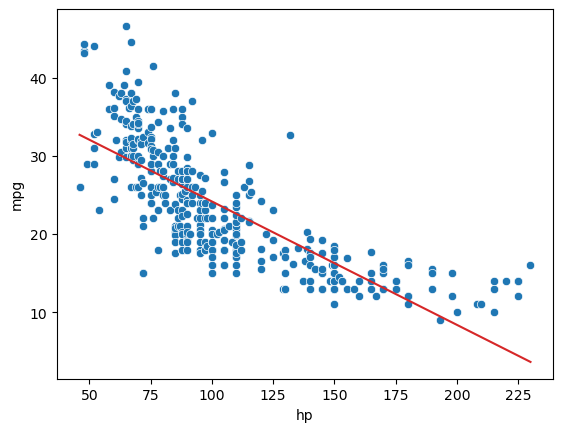

In [52]:
X = vehicles[["hp"]]
y = vehicles["mpg"]

hp_model = lm.LinearRegression()
hp_model.fit(X, y)
hp_model_predictions = hp_model.predict(X)

sns.scatterplot(data=vehicles, x="hp", y="mpg")

plt.plot(vehicles["hp"], hp_model_predictions, c="tab:red");

print(f"MSE of model with (hp) feature: {np.mean((y-hp_model_predictions)**2)}")

To capture the non-linear relationship between the variables, we can introduce a non-linear feature: `hp` squared. Our new model is:

$$\hat{y} = \theta_0 + \theta_1 (\text{hp}) + \theta_2 (\text{hp}^2)$$

MSE of model with (hp^2) feature: 18.984768907617216


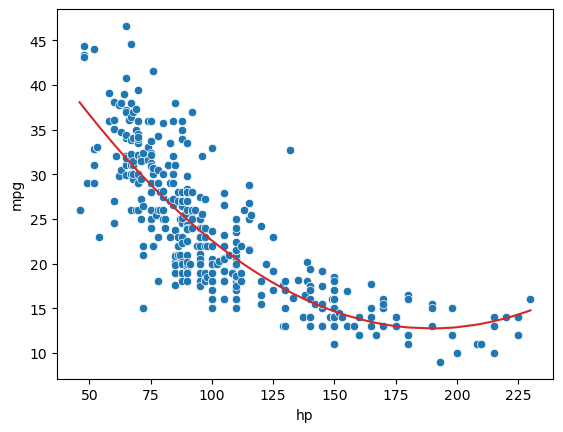

In [53]:
X = vehicles[["hp"]]
X.loc[:, "hp^2"] = vehicles["hp"]**2

hp2_model = lm.LinearRegression()
hp2_model.fit(X, y)
hp2_model_predictions = hp2_model.predict(X)

sns.scatterplot(data=vehicles, x="hp", y="mpg")

plt.plot(vehicles["hp"], hp2_model_predictions, c="tab:red");

print(f"MSE of model with (hp^2) feature: {np.mean((y-hp2_model_predictions)**2)}")

What if we take things further and add even *more* polynomial features?

The cell below fits models of increasing complexity and computes their MSEs.

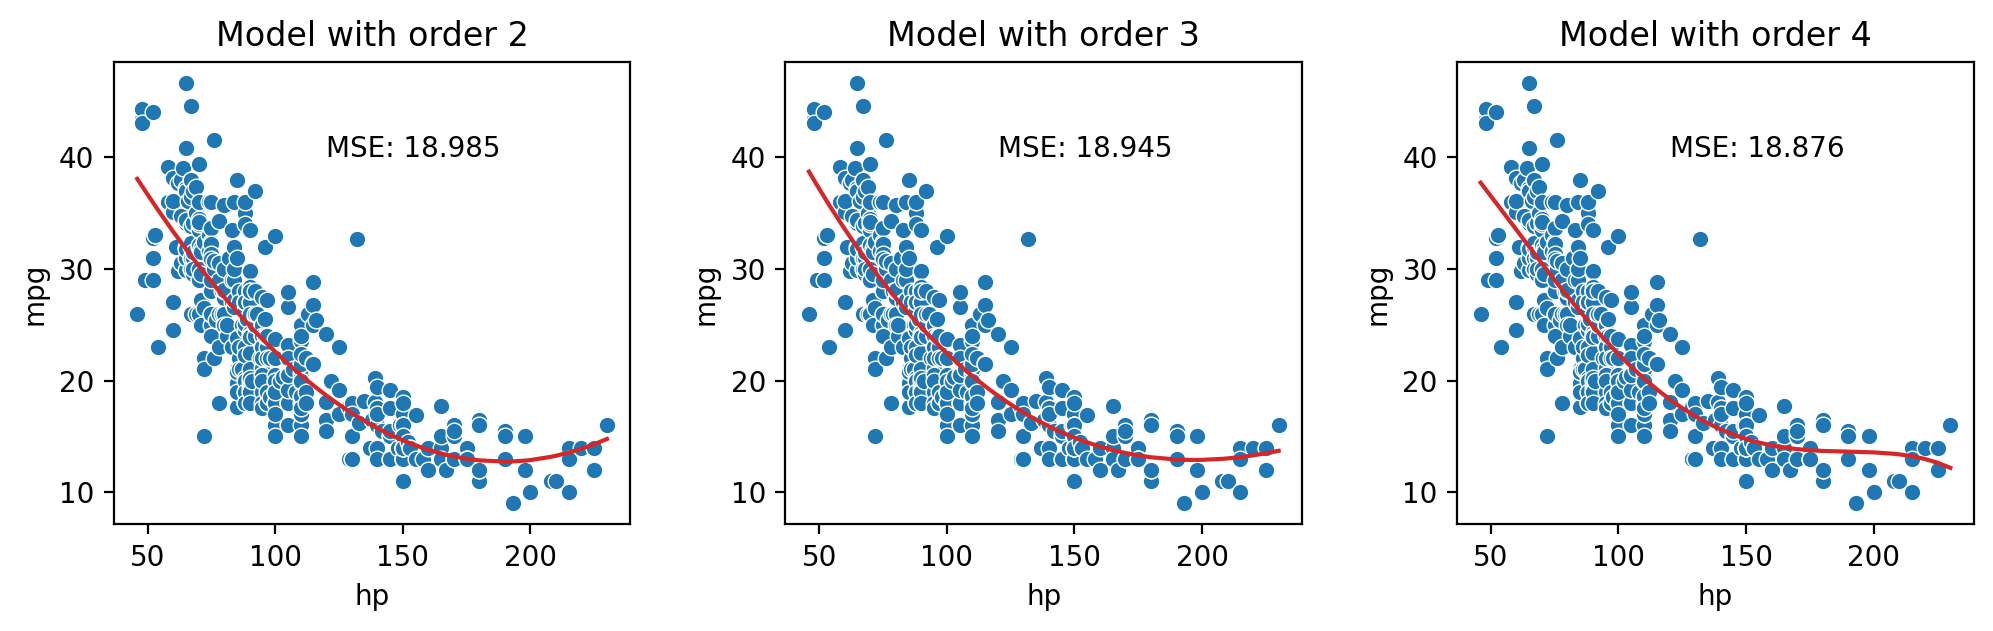

In [54]:
def mse(predictions, observations):
    return np.mean((observations - predictions)**2)

# Add hp^3 and hp^4 as features to the data
X["hp^3"] = vehicles["hp"]**3
X["hp^4"] = vehicles["hp"]**4

# Fit a model with order 3
hp3_model = lm.LinearRegression()
hp3_model.fit(X[["hp", "hp^2", "hp^3"]], vehicles["mpg"])
hp3_model_predictions = hp3_model.predict(X[["hp", "hp^2", "hp^3"]])

# Fit a model with order 4
hp4_model = lm.LinearRegression()
hp4_model.fit(X[["hp", "hp^2", "hp^3", "hp^4"]], vehicles["mpg"])
hp4_model_predictions = hp4_model.predict(X[["hp", "hp^2", "hp^3", "hp^4"]])

# Plot the models' predictions
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

predictions_dict = {0:hp2_model_predictions, 1:hp3_model_predictions, 2:hp4_model_predictions}

for i in predictions_dict:
    ax[i].scatter(vehicles["hp"], vehicles["mpg"], edgecolor="white", lw=0.5)
    ax[i].plot(vehicles["hp"], predictions_dict[i], "tab:red")
    ax[i].set_title(f"Model with order {i+2}")
    ax[i].set_xlabel("hp")
    ax[i].set_ylabel("mpg")
    ax[i].annotate(f"MSE: {np.round(mse(vehicles['mpg'], predictions_dict[i]), 3)}", (120, 40))

plt.subplots_adjust(wspace=0.3);

## Complexity and Overfitting

What we saw above was the phenomenon of **model complexity** – as we add additional features to the design matrix, the model becomes increasingly *complex*. Models with higher complexity have lower values of training error. Intuitively, this makes sense: with more features at its disposal, the model can match the observations in the trainining data more and more closely. 

We can run an experiment to see this in action. In the cell below, we fit many models of progressively higher complexity, then plot the MSE of predictions on the training set. The code used (specifically, the `Pipeline` and `PolynomialFeatures` functions of `sklearn`) is out of scope.

The **order** of a polynomial model is the highest power of any term in the model. An order 0 model takes the form $\hat{y} = \theta_0$, while an order 4 model takes the form $\hat{y} = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 + \theta_4 x^4$.

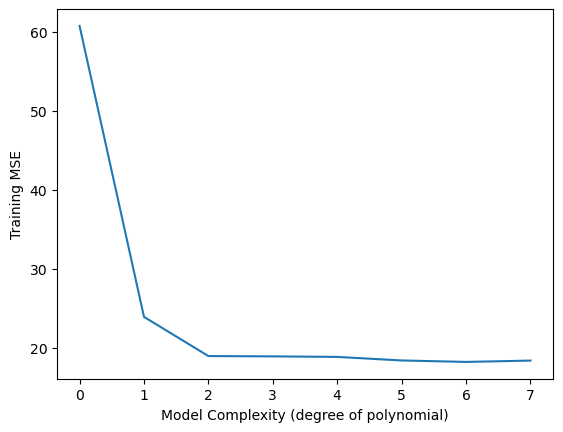

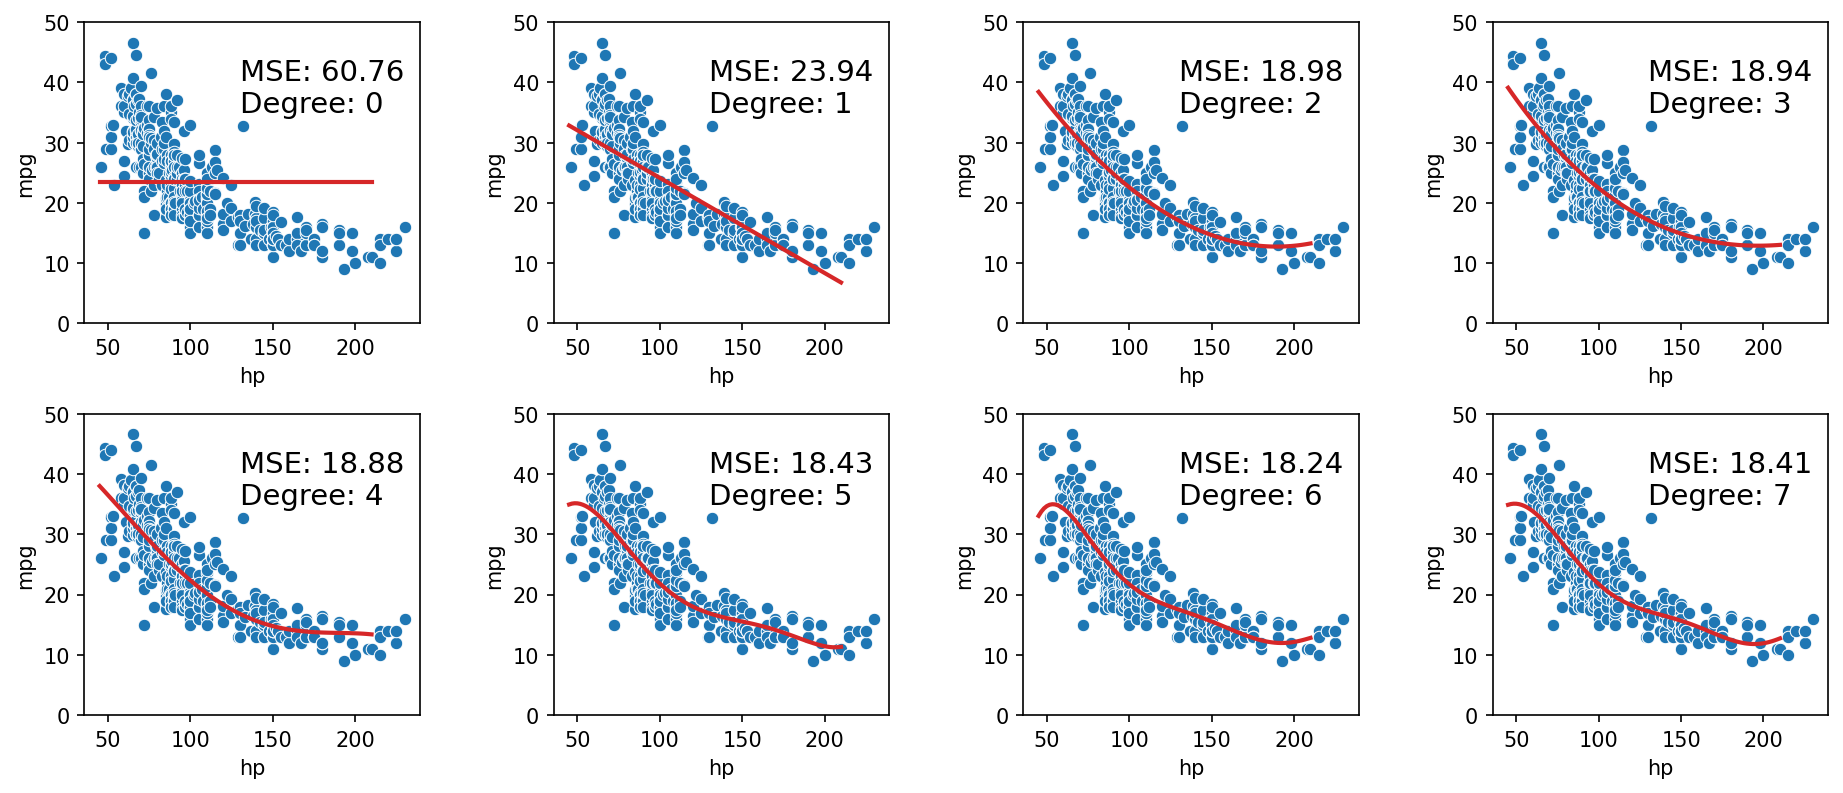

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def fit_model_dataset(degree, dataset):
    pipelined_model = Pipeline([
            ('polynomial_transformation', PolynomialFeatures(degree)),
            ('linear_regression', lm.LinearRegression())    
        ])

    pipelined_model.fit(dataset[["hp"]], dataset["mpg"])
    return mse(dataset['mpg'], pipelined_model.predict(dataset[["hp"]]))

errors = [fit_model_dataset(degree, vehicles) for degree in range(0, 8)]
MSEs_and_k = pd.DataFrame({"k": range(0, 8), "MSE": errors})

plt.plot(range(0, 8), errors)
plt.xlabel("Model Complexity (degree of polynomial)")
plt.ylabel("Training MSE");

def plot_degree_k_model(k, MSEs_and_k, axs):
    pipelined_model = Pipeline([
        ('poly_transform', PolynomialFeatures(degree = k)),
        ('regression', lm.LinearRegression(fit_intercept = True))    
    ])
    pipelined_model.fit(vehicles[["hp"]], vehicles["mpg"])
    
    row = k // 4
    col = k % 4
    ax = axs[row, col]
    
    sns.scatterplot(data=vehicles, x='hp', y='mpg', ax=ax)
    
    x_range = np.linspace(45, 210, 100).reshape(-1, 1)
    ax.plot(x_range, pipelined_model.predict(pd.DataFrame(x_range, columns=['hp'])), c='tab:red', linewidth=2)
    
    ax.set_ylim((0, 50))
    mse_str = f"MSE: {MSEs_and_k.loc[k, 'MSE']:.4}\nDegree: {k}"
    ax.text(130, 35, mse_str, dict(size=14))

fig = plt.figure(figsize=(15, 6), dpi=150)
axs = fig.subplots(nrows=2, ncols=4)

for k in range(8):
    plot_degree_k_model(k, MSEs_and_k, axs)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

As the model increases in polynomial degree (that is, it increases in complexity), the training MSE decreases, plateauing at roughly ~18.

In fact, it is a mathematical fact that if we create a polynomial model with degree $n-1$, we can *perfectly* model a set of $n$ points. For example, a set of 5 points can be perfectly modeled by a degree 4 model.

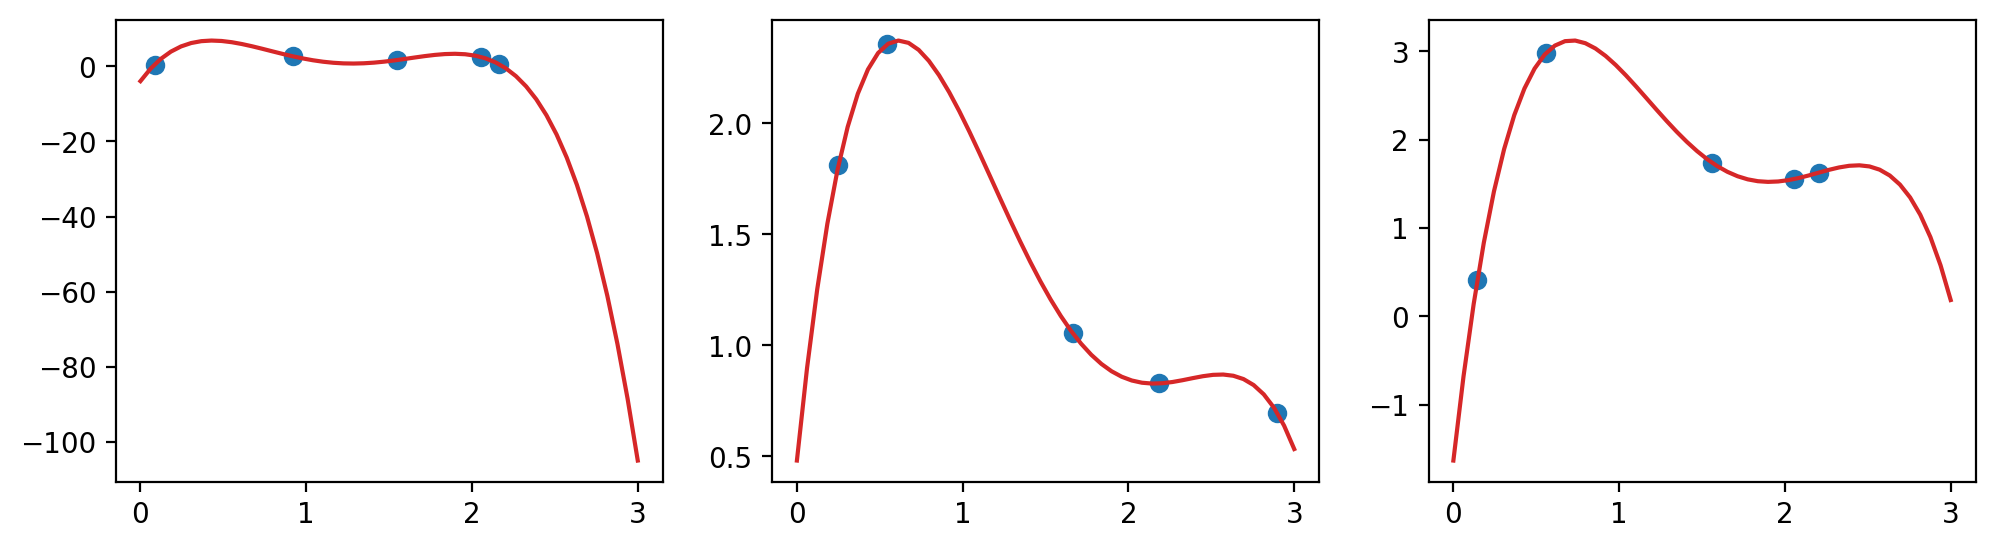

In [56]:
np.random.seed(101)

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

for i in range(0, 3):
    points = 3*np.random.uniform(size=(5, 2))

    polynomial_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(4)),
                ('linear_regression', lm.LinearRegression())    
            ])

    polynomial_model.fit(points[:, [0]], points[:, 1])

    ax[i].scatter(points[:, 0], points[:, 1])

    xs = np.linspace(0, 3)
    ax[i].plot(xs, polynomial_model.predict(xs[:, np.newaxis]), c="tab:red");

You may be tempted to always design models with high polynomial degree – after all, we know that we could theoretically achieve perfect predictions by creating a model with enough polynomial features. 

It turns out that the examples we looked at above represent a somewhat artificial scenario: we trained our model on all the data we had available, then used the model to make predictions on this very same dataset. A more realistic situation is when we wish to apply our model on unseen data – that is, datapoints that it did not encounter during the model fitting process. 

Suppose we obtain a random sample of 6 datapoints from our population of vehicle data. We want to train a model on these 6 points and use it to make predictions on unseen data (perhaps cars for which we don't already know the true `mpg`). 

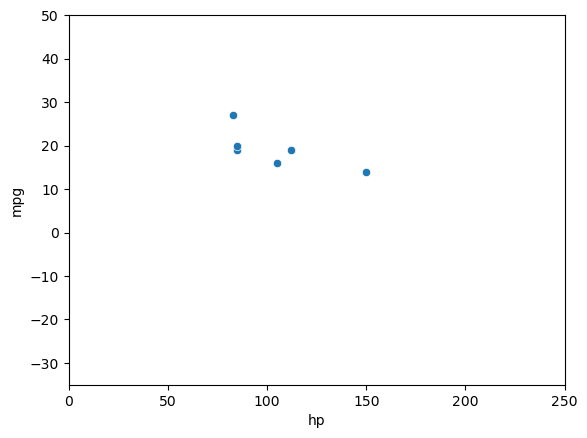

In [57]:
np.random.seed(100)

sample_6 = vehicles.sample(6)

sns.scatterplot(data=sample_6, x="hp", y="mpg")
plt.ylim(-35, 50)
plt.xlim(0, 250);

If we design a model with polynomial degree 5, we can make perfect predictions on this sample of training data.

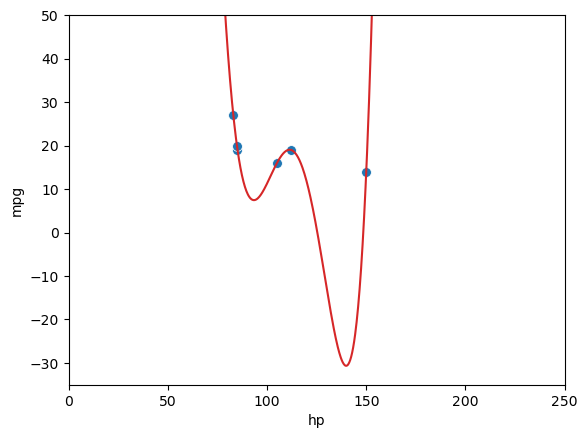

In [58]:
degree_5_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(5)),
                ('linear_regression', lm.LinearRegression())    
            ])

degree_5_model.fit(sample_6[["hp"]], sample_6["mpg"])
xs = np.linspace(0, 250, 1000)
degree_5_model_predictions = degree_5_model.predict(xs[:, np.newaxis])

plt.plot(xs, degree_5_model_predictions, c="tab:red")
sns.scatterplot(data=sample_6, x="hp", y="mpg", s=50)
plt.ylim(-35, 50)
plt.xlim(0, 250);

However, when we reapply this fitted model to the full population of data, it fails to capture the major trends of the dataset.

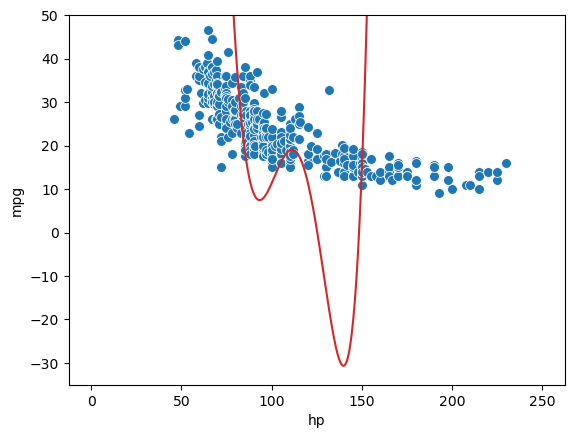

In [59]:
plt.plot(xs, degree_5_model_predictions, c="tab:red")
sns.scatterplot(data=vehicles, x="hp", y="mpg", s=50)
plt.ylim(-35, 50);

The model has **overfit** to the data used to train it. It has essentially "memorized" the six datapoints used during model fitting, and does not generalize well to new data. 

Complex models tend to be more sensitive to the data used to train them. The **variance** of a model refers to its tendency to vary depending on the training data used during model fitting. It turns out that our degree-5 model has very high model variance. If we randomly sample new sets of datapoints to use in training, the model varies erratically. 

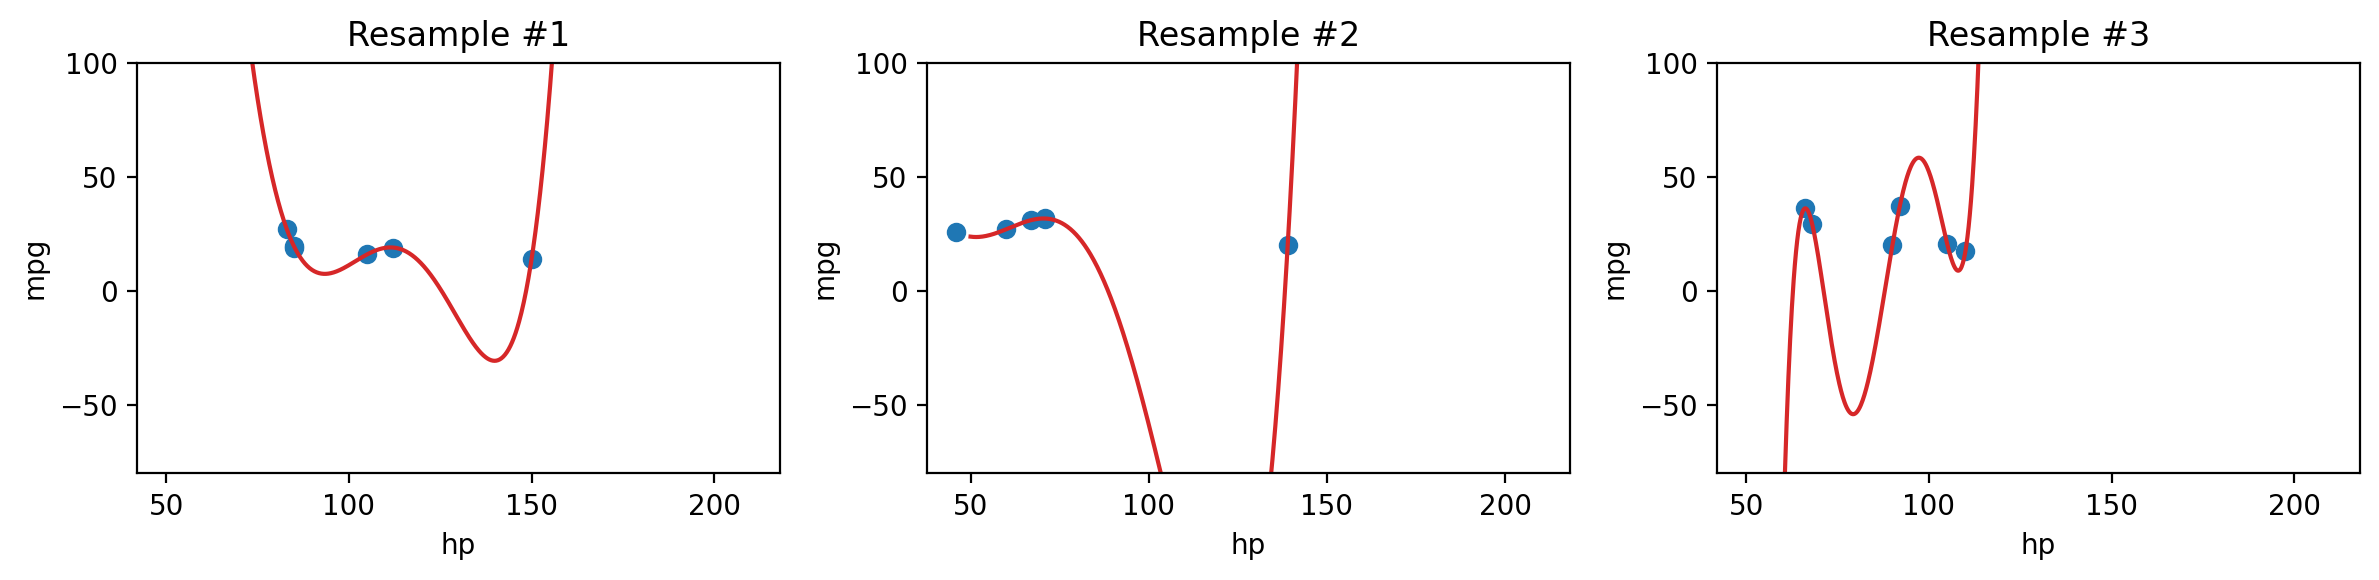

In [33]:
np.random.seed(100)

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

for i in range(0, 3):
    sample = vehicles.sample(6)

    polynomial_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(5)),
                ('linear_regression', lm.LinearRegression())    
            ])

    polynomial_model.fit(sample[["hp"]], sample["mpg"])

    ax[i].scatter(sample[["hp"]], sample["mpg"])

    xs = np.linspace(50, 210, 1000)
    ax[i].plot(xs, polynomial_model.predict(xs[:, np.newaxis]), c="tab:red")
    ax[i].set_ylim(-80, 100)
    ax[i].set_xlabel("hp")
    ax[i].set_ylabel("mpg")
    ax[i].set_title(f"Resample #{i+1}")
    
fig.tight_layout();